In [1]:
import fiftyone as fo
import fiftyone.zoo as foz
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 1. 加载visdrone val数据集

In [2]:
visdrone_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path="/home/wsg/dataset/VisDrone_Dataset_COCO_Format/images/instances_UAVval",
    labels_path="/home/wsg/dataset/VisDrone_Dataset_COCO_Format/annotations/instances_UAVval.json",
    label_types=["detections"],
    include_id=True,
)

 100% |█████████████████| 548/548 [15.8s elapsed, 0s remaining, 34.0 samples/s]      


In [3]:
print(visdrone_dataset.first()["detections"]["detections"][13]["bounding_box"])   #存储的(x,y,w,h),相较于原图尺度\
print(visdrone_dataset.first()["detections"]["detections"][13]["label"])

[0.5485294117647059, 0.27712418300653596, 0.005147058823529412, 0.026143790849673203]
pedestrian


In [4]:
print(visdrone_dataset.default_classes)
print(visdrone_dataset)

['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor']
Name:        2022.11.21.15.32.10
Media type:  image
Num samples: 548
Persistent:  False
Tags:        []
Sample fields:
    id:         fiftyone.core.fields.ObjectIdField
    filepath:   fiftyone.core.fields.StringField
    tags:       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    coco_id:    fiftyone.core.fields.IntField


In [5]:
# 训练集的gt
visdrone_dataset_train = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path="/home/wsg/dataset/VisDrone_Dataset_COCO_Format/images/instances_UAVtrain",
    labels_path="/home/wsg/dataset/VisDrone_Dataset_COCO_Format/annotations/instances_UAVtrain.json",
    label_types=["detections"],
    include_id=True,
)

 100% |███████████████| 6471/6471 [2.4m elapsed, 0s remaining, 47.1 samples/s]      


## 分析instance 和ap的关系

In [6]:
val_cls_instance_num = visdrone_dataset.count_values("detections.detections.label")
train_cls_instance_num = visdrone_dataset_train.count_values("detections.detections.label")

In [35]:
val_cls_instance_num

{'motor': 4886,
 'people': 5125,
 'car': 14064,
 'bicycle': 1287,
 'truck': 750,
 'van': 1975,
 'bus': 251,
 'tricycle': 1045,
 'awning-tricycle': 532,
 'pedestrian': 8844}

In [38]:
df_instance = pd.DataFrame([],columns=["train_instance","val_instance"])
for i,key in enumerate(train_cls_instance_num.keys()):
    df_instance.loc[i] = [train_cls_instance_num[key],val_cls_instance_num[key]]
df_instance.index = train_cls_instance_num.keys()

<AxesSubplot:title={'center':'instance num'}>

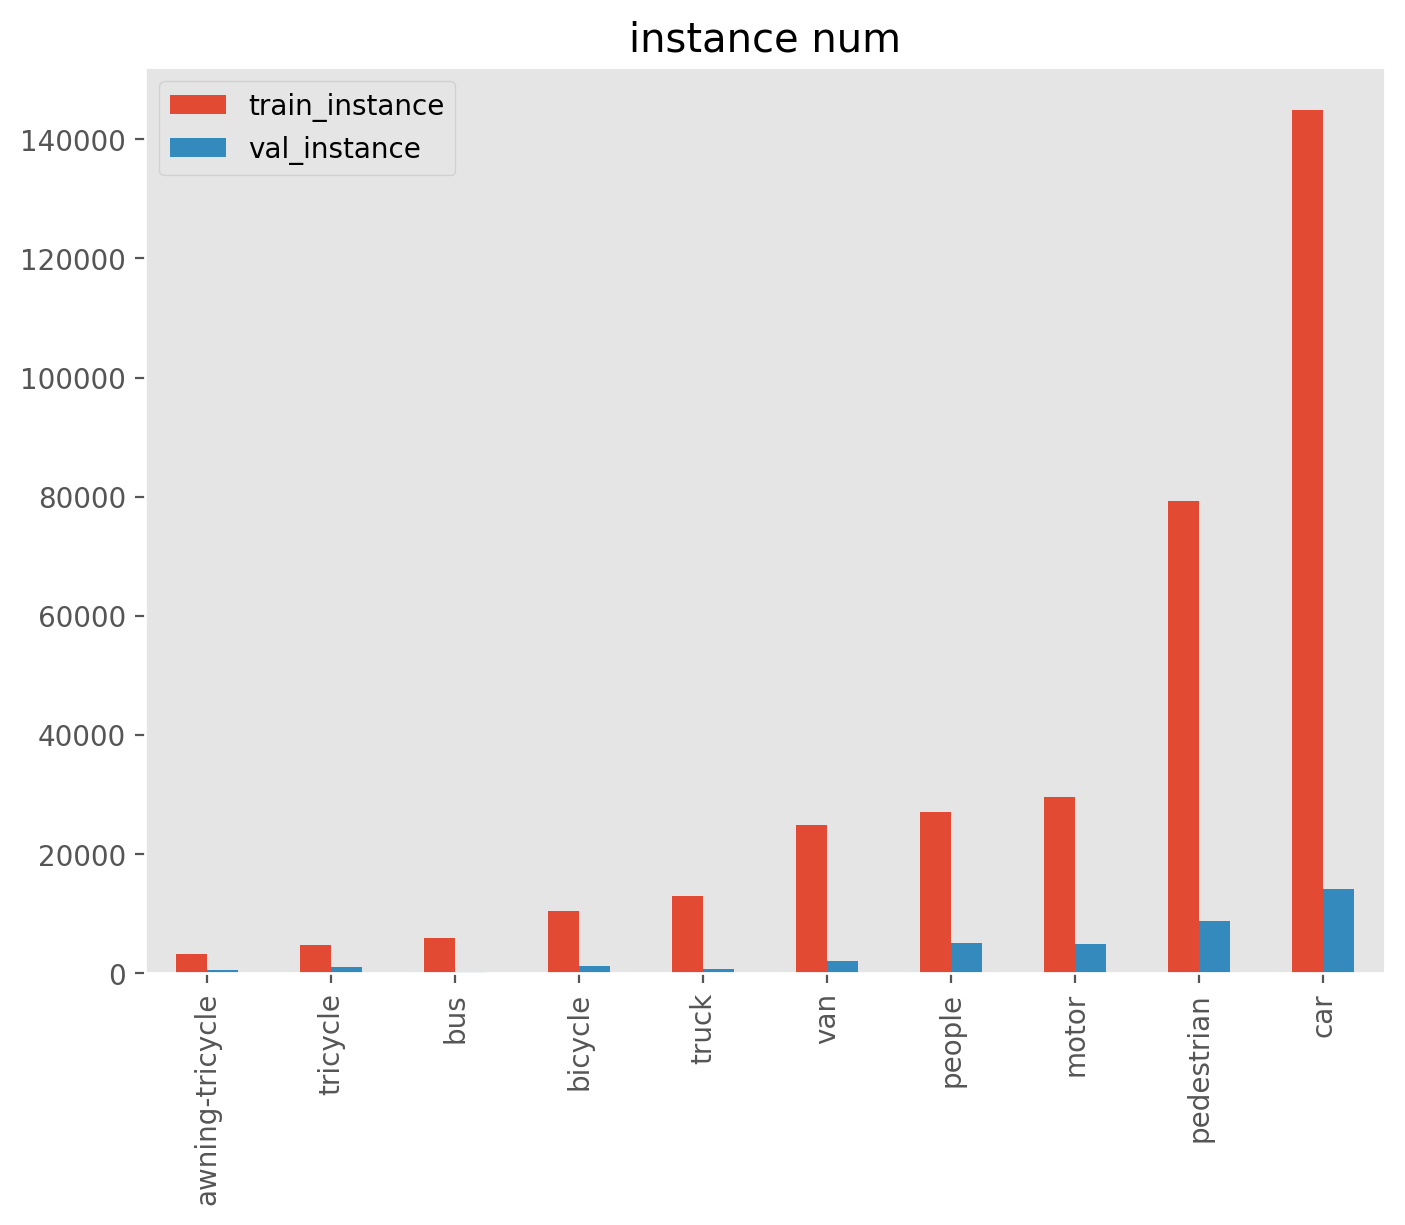

In [39]:
fig = plt.figure(dpi=200,figsize=(8,6))
plt.style.use('ggplot')
df_instance.sort_values("train_instance",inplace=True)
ax = plt.subplot(1, 1, 1)   #添加子图
df_instance.plot(kind="bar",title="instance num",grid=False,ax=ax)

In [7]:
val_instance_num =  sum(val_cls_instance_num.values())
train_instance_num = sum(train_cls_instance_num.values())
val_cls_instance_num_list = []
train_cls_instance_num_list = []
for key in visdrone_dataset.default_classes:
    val_cls_instance_num_list.append((key,val_cls_instance_num[key] / val_instance_num))
    train_cls_instance_num_list.append((key,train_cls_instance_num[key] / train_instance_num))

In [8]:
print(val_cls_instance_num_list)
print(train_cls_instance_num_list)

[('pedestrian', 0.22817926159085633), ('people', 0.13222735364689492), ('bicycle', 0.03320519105240073), ('car', 0.3628576588663278), ('van', 0.050955907015144866), ('truck', 0.019350344436130963), ('tricycle', 0.026961479914342477), ('awning-tricycle', 0.013725844320028897), ('bus', 0.006475915271291829), ('motor', 0.12606104388658118)]
[('pedestrian', 0.23116572067924615), ('people', 0.07884232118506777), ('bicycle', 0.030535774641321196), ('car', 0.42209881003717903), ('van', 0.07271477022412326), ('truck', 0.03751413153692847), ('tricycle', 0.014020815608209695), ('awning-tricycle', 0.009457931725737462), ('bus', 0.017266698523327233), ('motor', 0.08638302583885969)]


In [9]:
# 计算AP和instance的关系
ufpmp_cls_ap = [('car',0.643),('bus',0.564),('van',0.452),('truck',0.369),('pedestrian',0.343),('motor',0.333),('tricycle',0.266),('people',0.244),('bicycle',0.208),('awning-tricycle',0.176)]
print(list(map(lambda x: x[0],sorted(val_cls_instance_num_list,key=lambda x:x[1]))))
print(list(map(lambda x: x[0],sorted(train_cls_instance_num_list,key=lambda x:x[1]))))
print(list(map(lambda x: x[0],sorted(ufpmp_cls_ap,key=lambda x:x[1]))))

['bus', 'awning-tricycle', 'truck', 'tricycle', 'bicycle', 'van', 'motor', 'people', 'pedestrian', 'car']
['awning-tricycle', 'tricycle', 'bus', 'bicycle', 'truck', 'van', 'people', 'motor', 'pedestrian', 'car']
['awning-tricycle', 'bicycle', 'people', 'tricycle', 'motor', 'pedestrian', 'truck', 'van', 'bus', 'car']


In [29]:
import pandas as pd
val_dt = {x[0]:x[1] for x in val_cls_instance_num_list}
train_dt = {x[0]:x[1] for x in train_cls_instance_num_list}
ap_dt = {x[0]:x[1] for x in ufpmp_cls_ap}
df = pd.DataFrame([],columns=["train_instance","val_instance","ufpmp_ap"])
for i,key in enumerate(val_dt.keys()):
    df.loc[i] = [train_dt[key],val_dt[key],ap_dt[key]]
df.index = val_dt.keys()
# df["ufpmp_ap"] = df["ufpmp_ap"] / sum(df["ufpmp_ap"]) 

<AxesSubplot:title={'center':'ap and instance num'}>

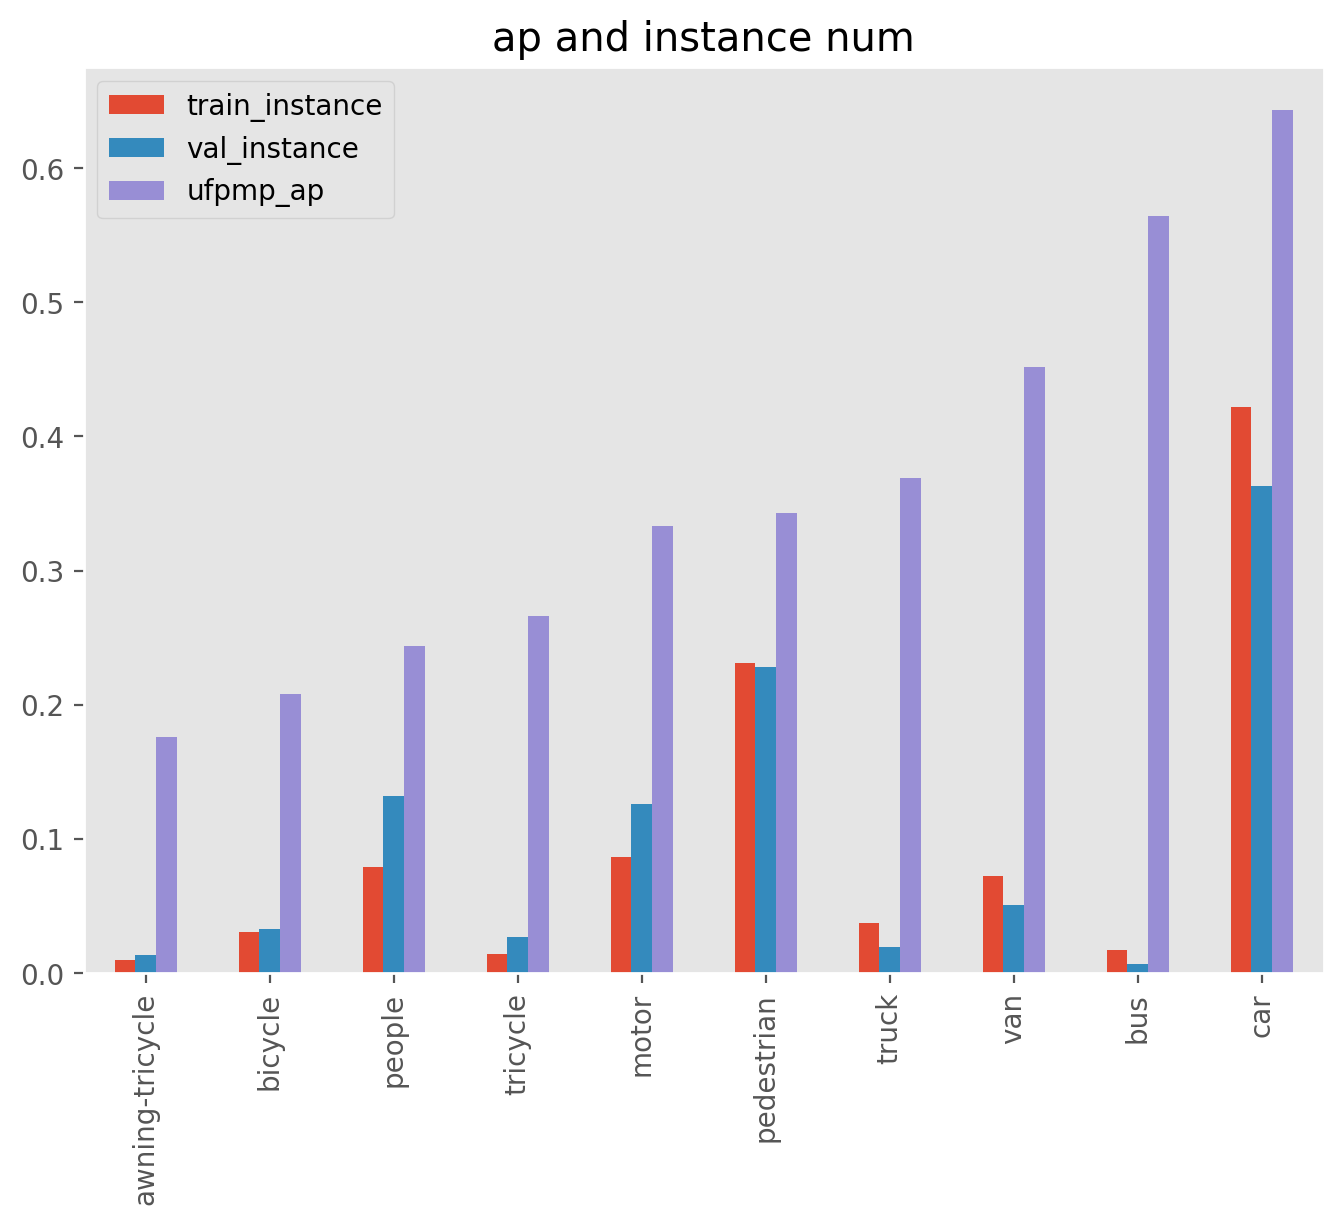

In [30]:
fig = plt.figure(dpi=200,figsize=(8,6))
plt.style.use('ggplot')
df.sort_values("ufpmp_ap",inplace=True)
ax = plt.subplot(1, 1, 1)   #添加子图
df.plot(kind="bar",title="ap and instance num",grid=False,ax=ax)

In [12]:
df.corr() #ap和训练集isntance以及验证集instance数目都呈现较强的相关性。

,train_instance,val_instance,ufpmp_ap
train_instance,1.000000,0.973467,0.595774
val_instance,0.973467,1.000000,0.476104
ufpmp_ap,0.595774,0.476104,1.000000


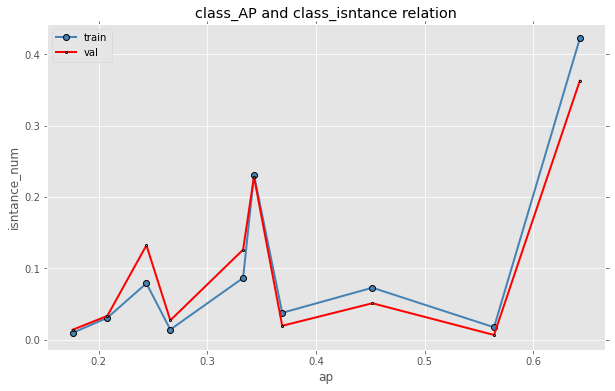

In [31]:
# 设置图框的大小
fig = plt.figure(figsize=(10,6))

# 绘图--阅读人数趋势
plt.plot(df.ufpmp_ap, # x轴数据
         df.train_instance, # y轴数据
         linestyle = '-', # 折线类型
         linewidth = 2, # 折线宽度
         color = 'steelblue', # 折线颜色
         marker = 'o', # 点的形状
         markersize = 6, # 点的大小
         markeredgecolor='black', # 点的边框色
         markerfacecolor='steelblue', # 点的填充色
         label = 'train') # 添加标签

# 绘图--阅读人次趋势
plt.plot(df.ufpmp_ap, # x轴数据
         df.val_instance, # y轴数据
         linestyle = '-', # 折线类型
         linewidth = 2, # 折线宽度
         color = 'r', # 折线颜色
         marker = 'o', # 点的形状
         markersize = 2, # 点的大小
         markeredgecolor='black', # 点的边框色
         markerfacecolor='#ff9999', # 点的填充色
         label = 'val') # 添加标签

# 添加标题和坐标轴标签
plt.title('class_AP and class_isntance relation')
plt.xlabel('ap')
plt.ylabel('isntance_num')

# 剔除图框上边界和右边界的刻度
plt.tick_params(top = 'off', right = 'off')

# 获取图的坐标信息
ax = plt.gca()
# 设置日期的显示格式  

# 显示图例
plt.legend()
# 显示图形
plt.show()


## 统计train和val中各个类别的尺度分布

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [57]:


def count_cls_scale(dataset):
    scale_count = {}
    for sample in dataset:
        dets = sample["detections"]["detections"]
        for det in dets:
            label = det["label"]
            _,_,w,h = det["bounding_box"]
            if label not in scale_count.keys():
                scale_count[label] = []
            scale_count[label].append((w*h)**0.5 * 100) #使用长和宽的乘积开方作为尺度，结果为相较于原图的百分比
    return scale_count
train_scale_count = count_cls_scale(visdrone_dataset_train)
val_scale_count = count_cls_scale(visdrone_dataset)


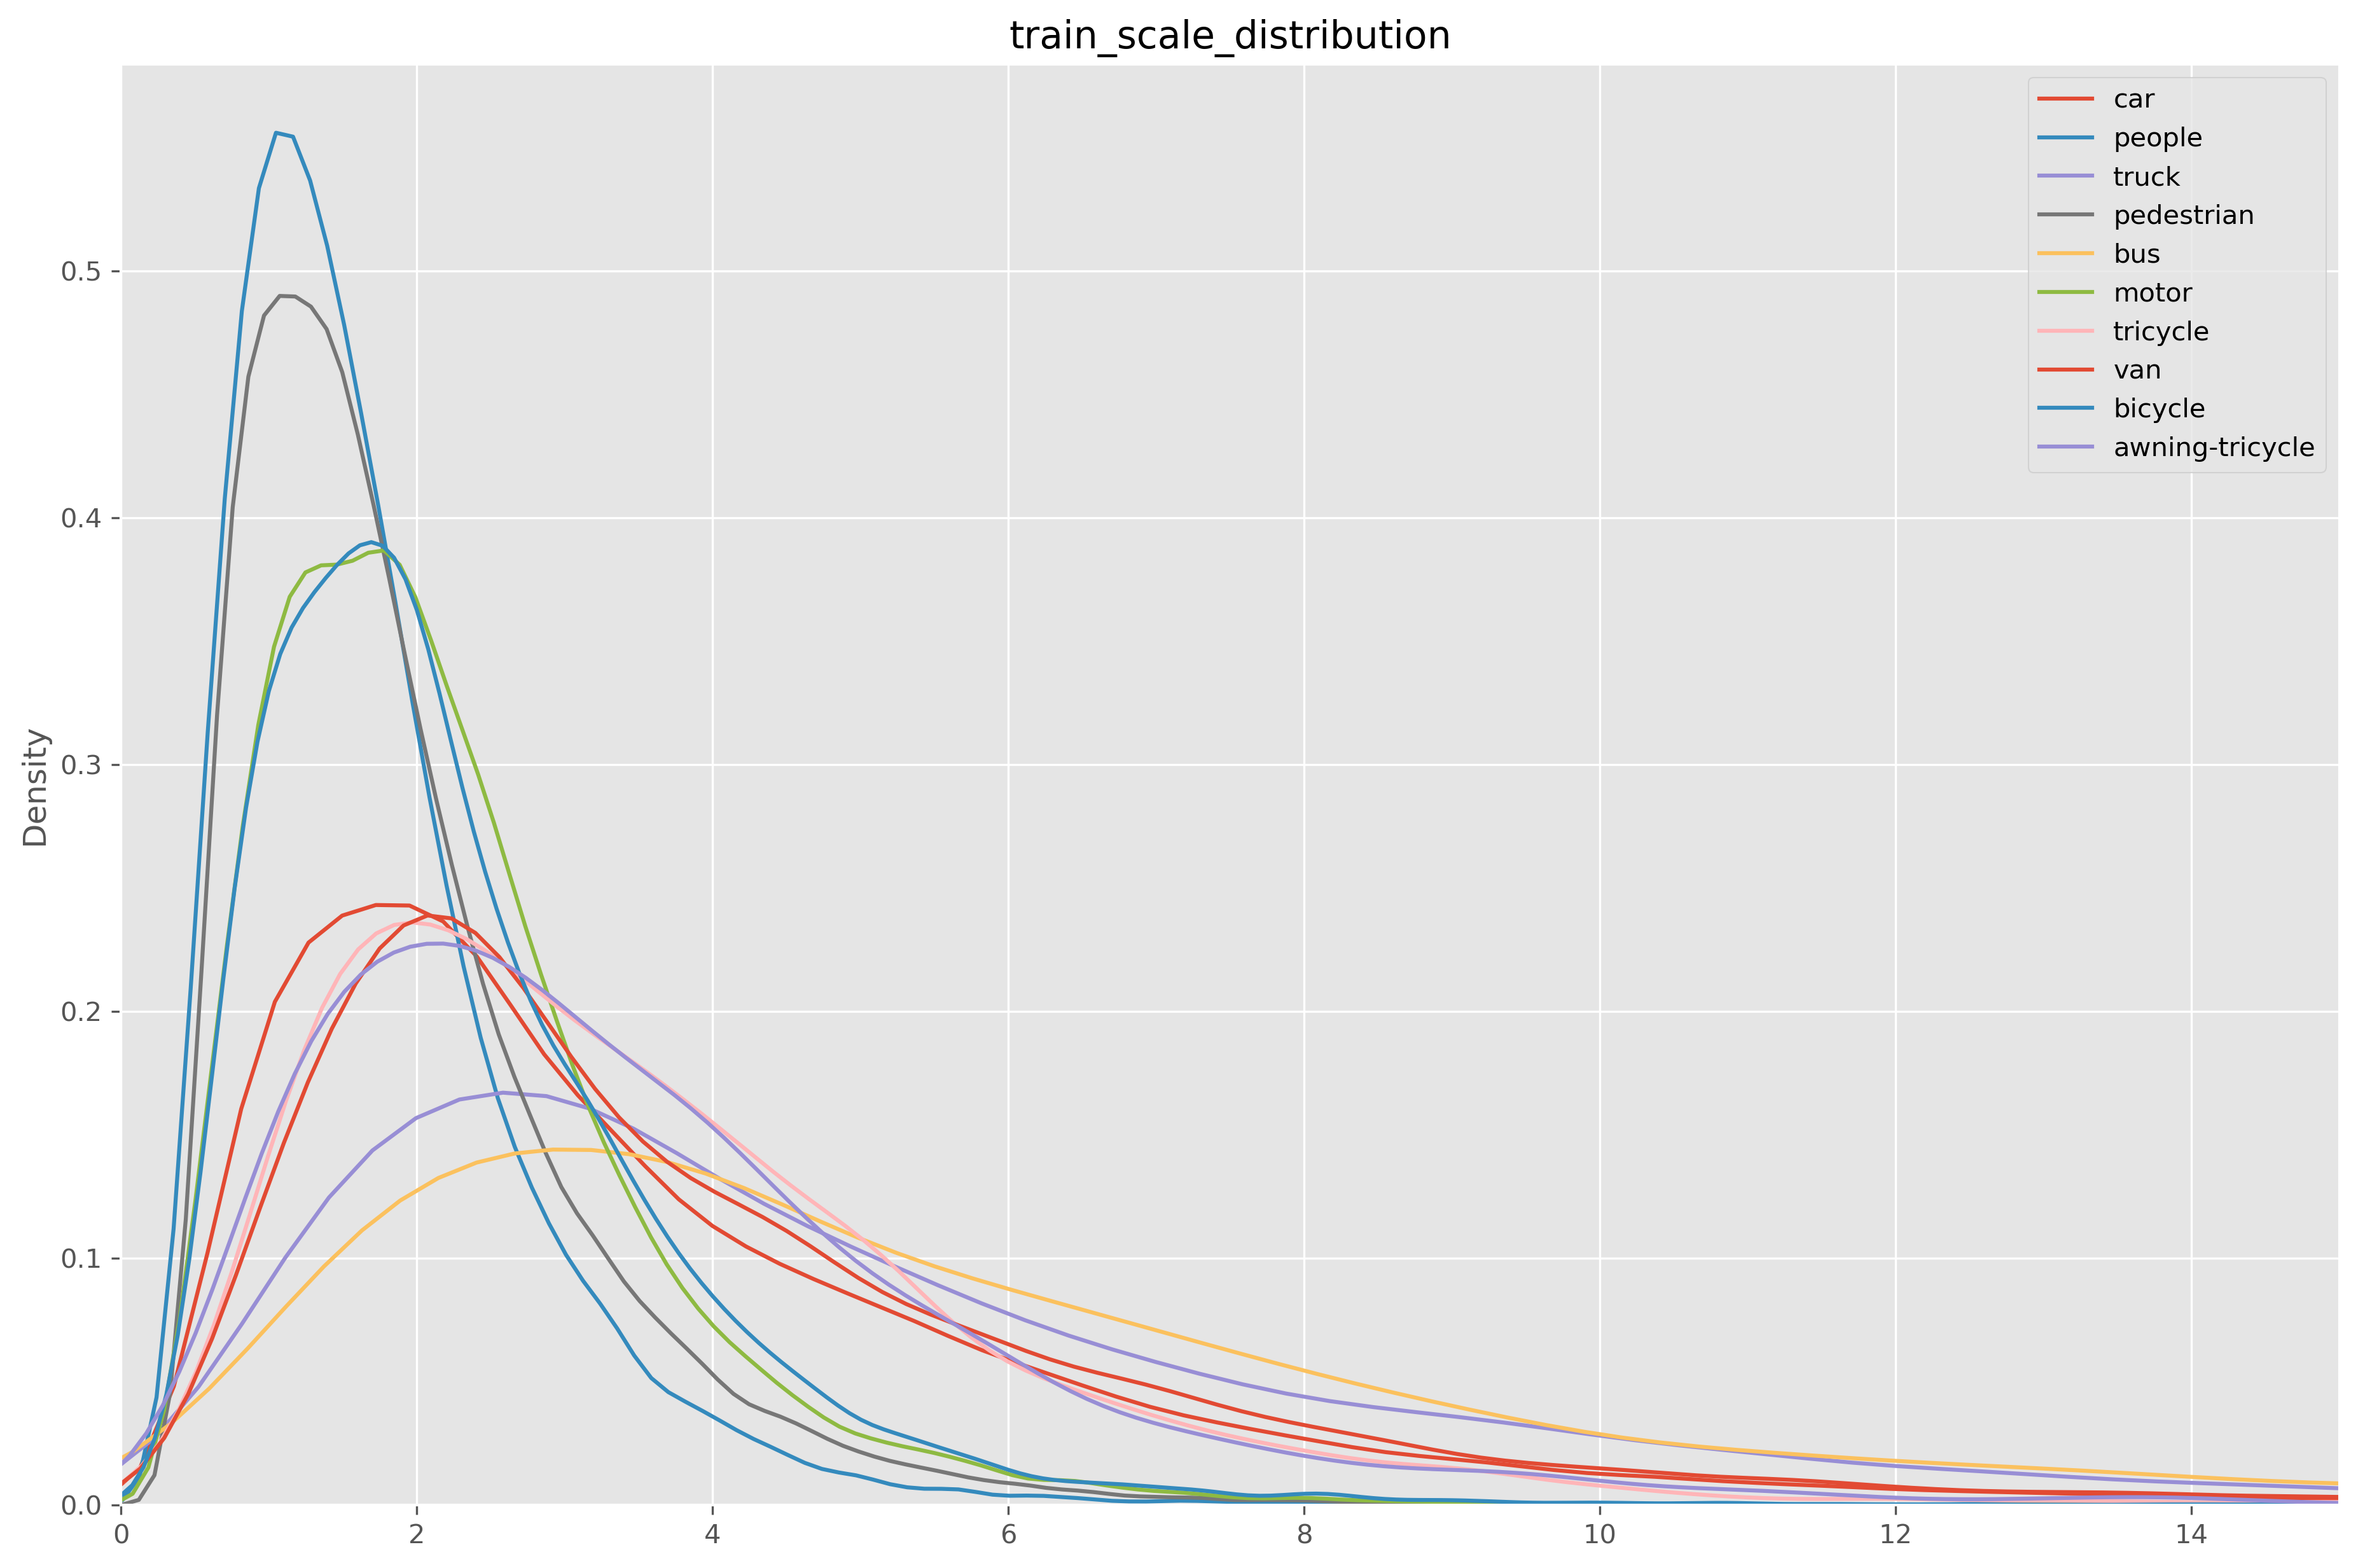

In [62]:
# 训练集各类别尺度分布差异
plt.figure(dpi=300,figsize=(15,10))
plt.title('train_scale_distribution')
plt.style.use('ggplot')
# plt.style.use('seaborn')
plt.rcParams['axes.unicode_minus']=False
plt.xlim((0,15))
for key in val_scale_count.keys():
    sns.kdeplot(train_scale_count[key], label = key,linestyle='-')
plt.legend()
plt.show()

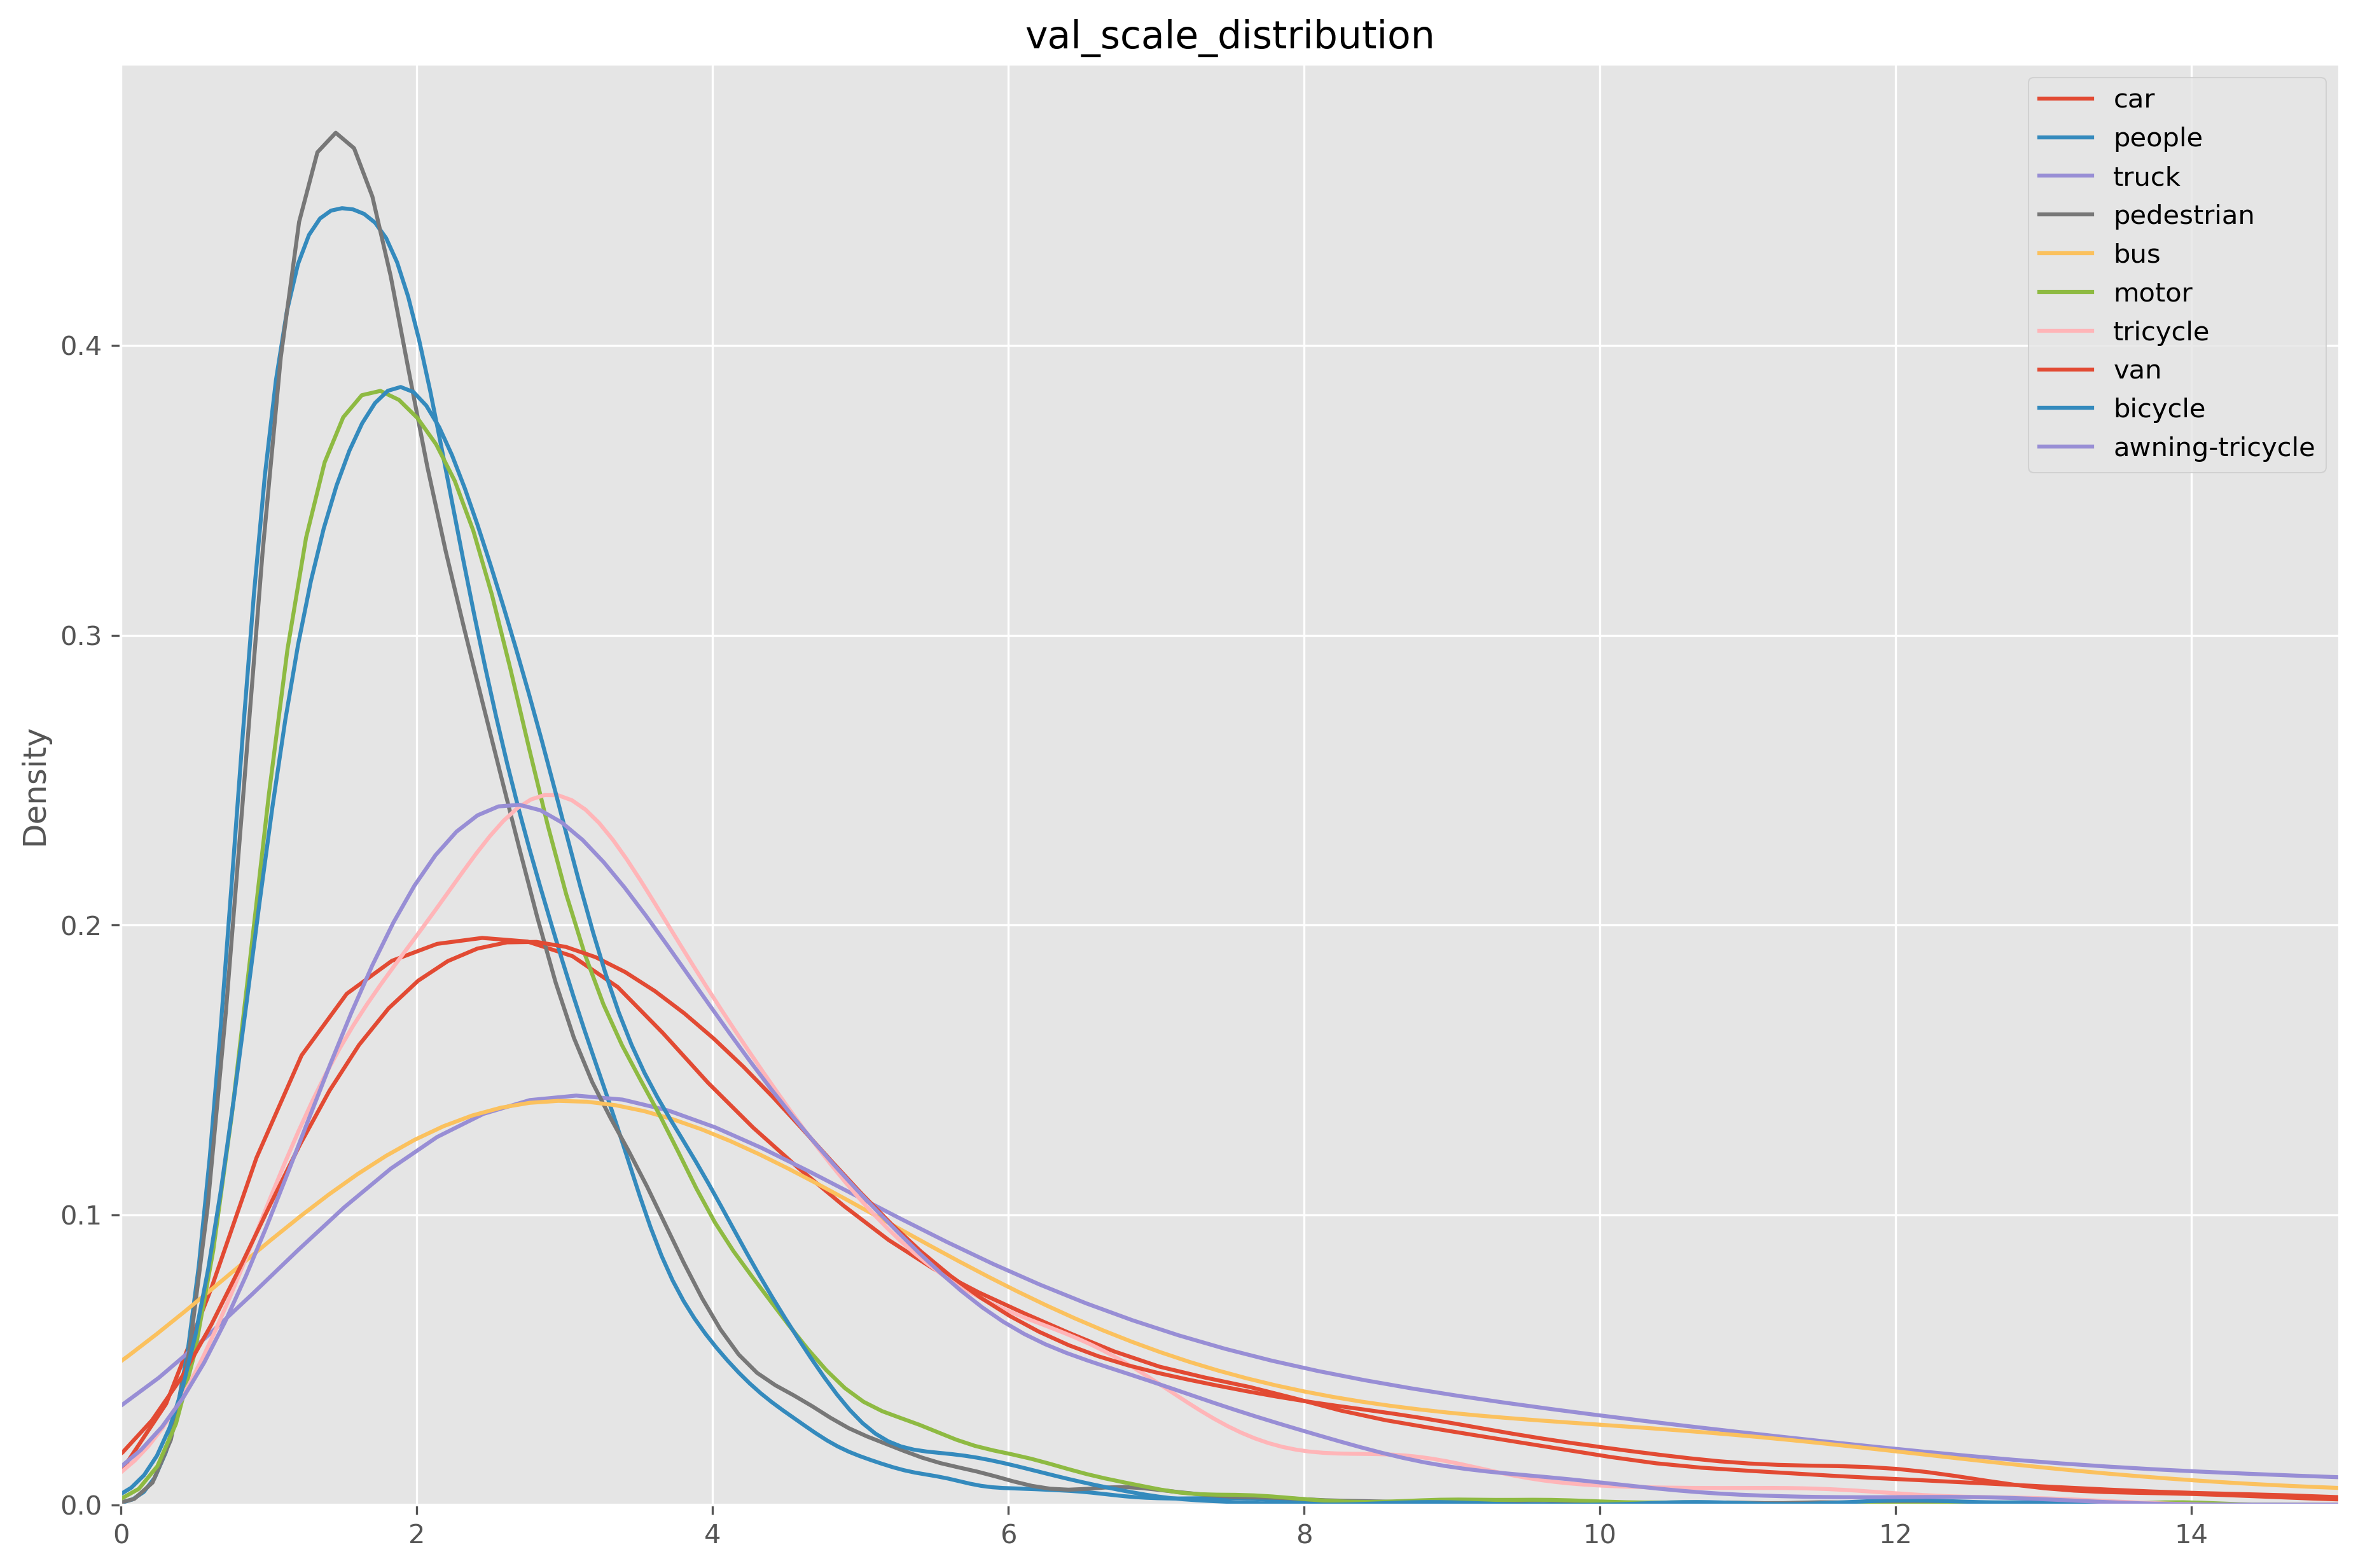

In [63]:
# 验证集各类别尺度分布差异
plt.figure(dpi=300,figsize=(15,10))
plt.title('val_scale_distribution')
plt.style.use('ggplot')
# plt.style.use('seaborn')
plt.rcParams['axes.unicode_minus']=False
plt.xlim((0,15))
for key in val_scale_count.keys():
    sns.kdeplot(val_scale_count[key], label = key,linestyle='-')
plt.legend()
plt.show()

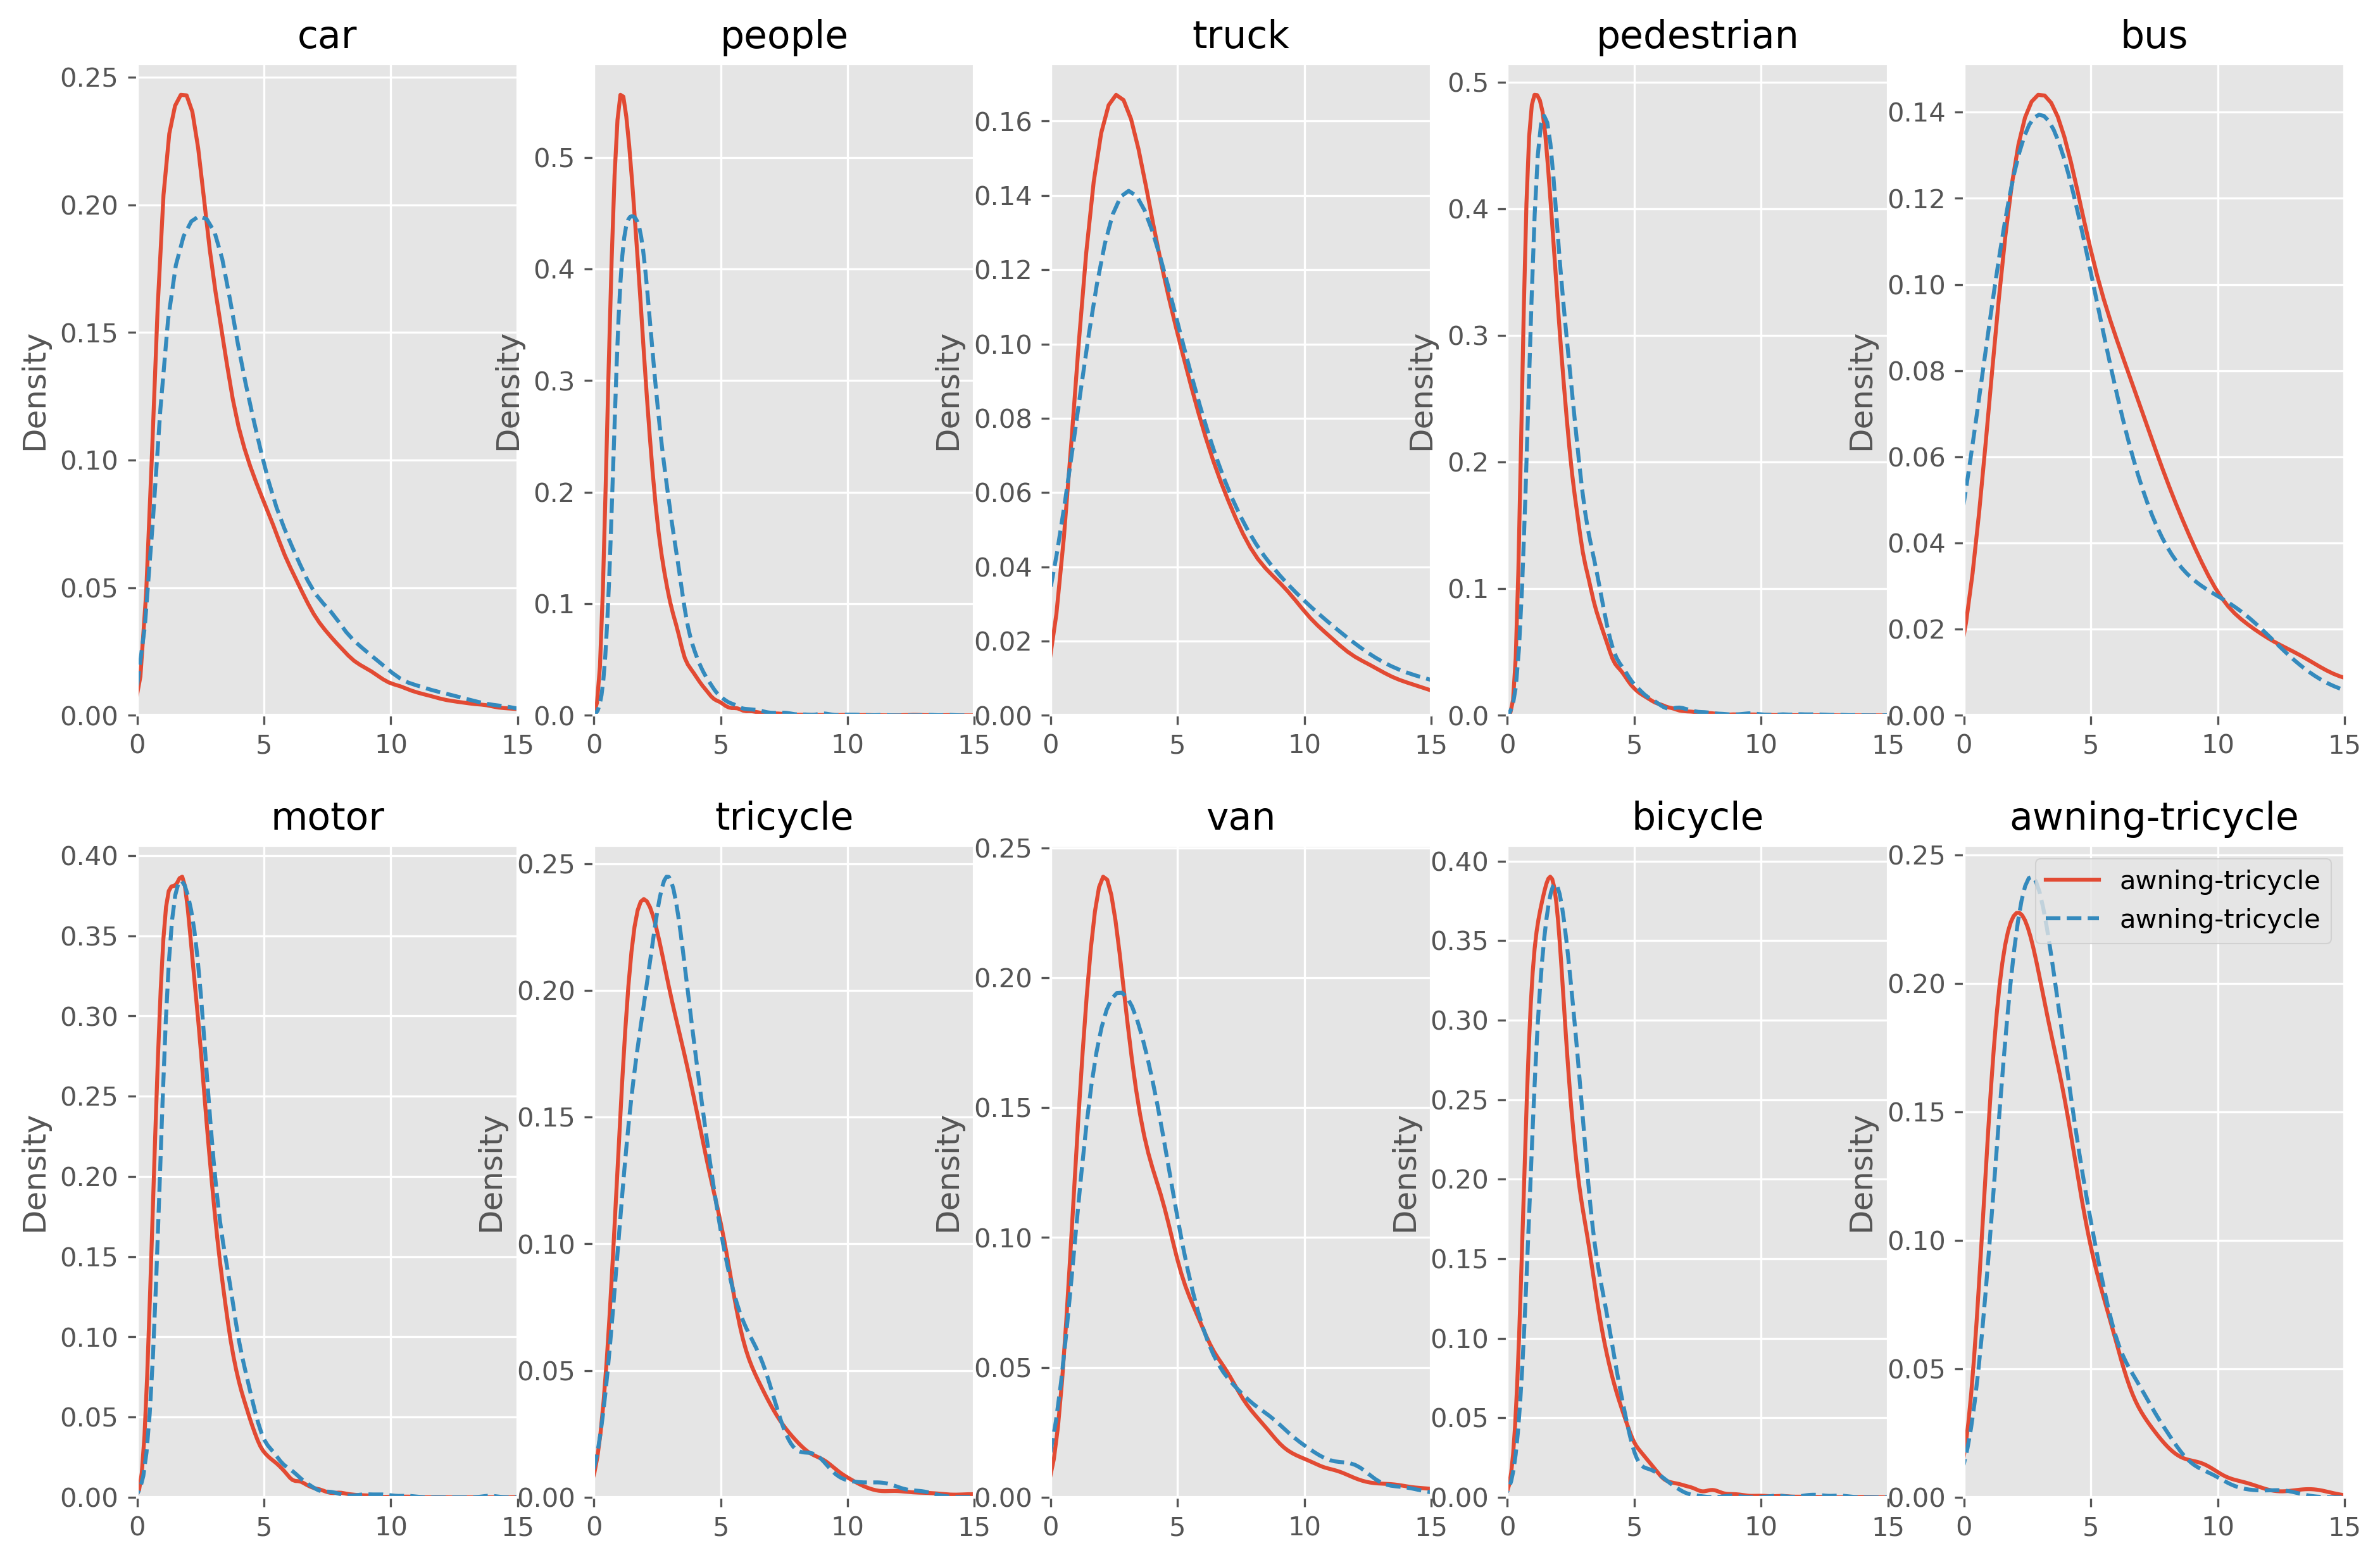

In [64]:
# 相同类别在训练集和验证集的分布差异
plt.figure(dpi=300,figsize=(15,10))
plt.style.use('ggplot')
# plt.style.use('seaborn')
plt.rcParams['axes.unicode_minus']=False
for i,key in  enumerate(val_scale_count.keys()):
    plt.subplot(2, 5, i+1)
    plt.xlim((0,15))
    plt.title(key)
    sns.kdeplot(train_scale_count[key], label = key,linestyle='-')
    sns.kdeplot(val_scale_count[key], label = key,linestyle='--')
plt.legend()
plt.show()

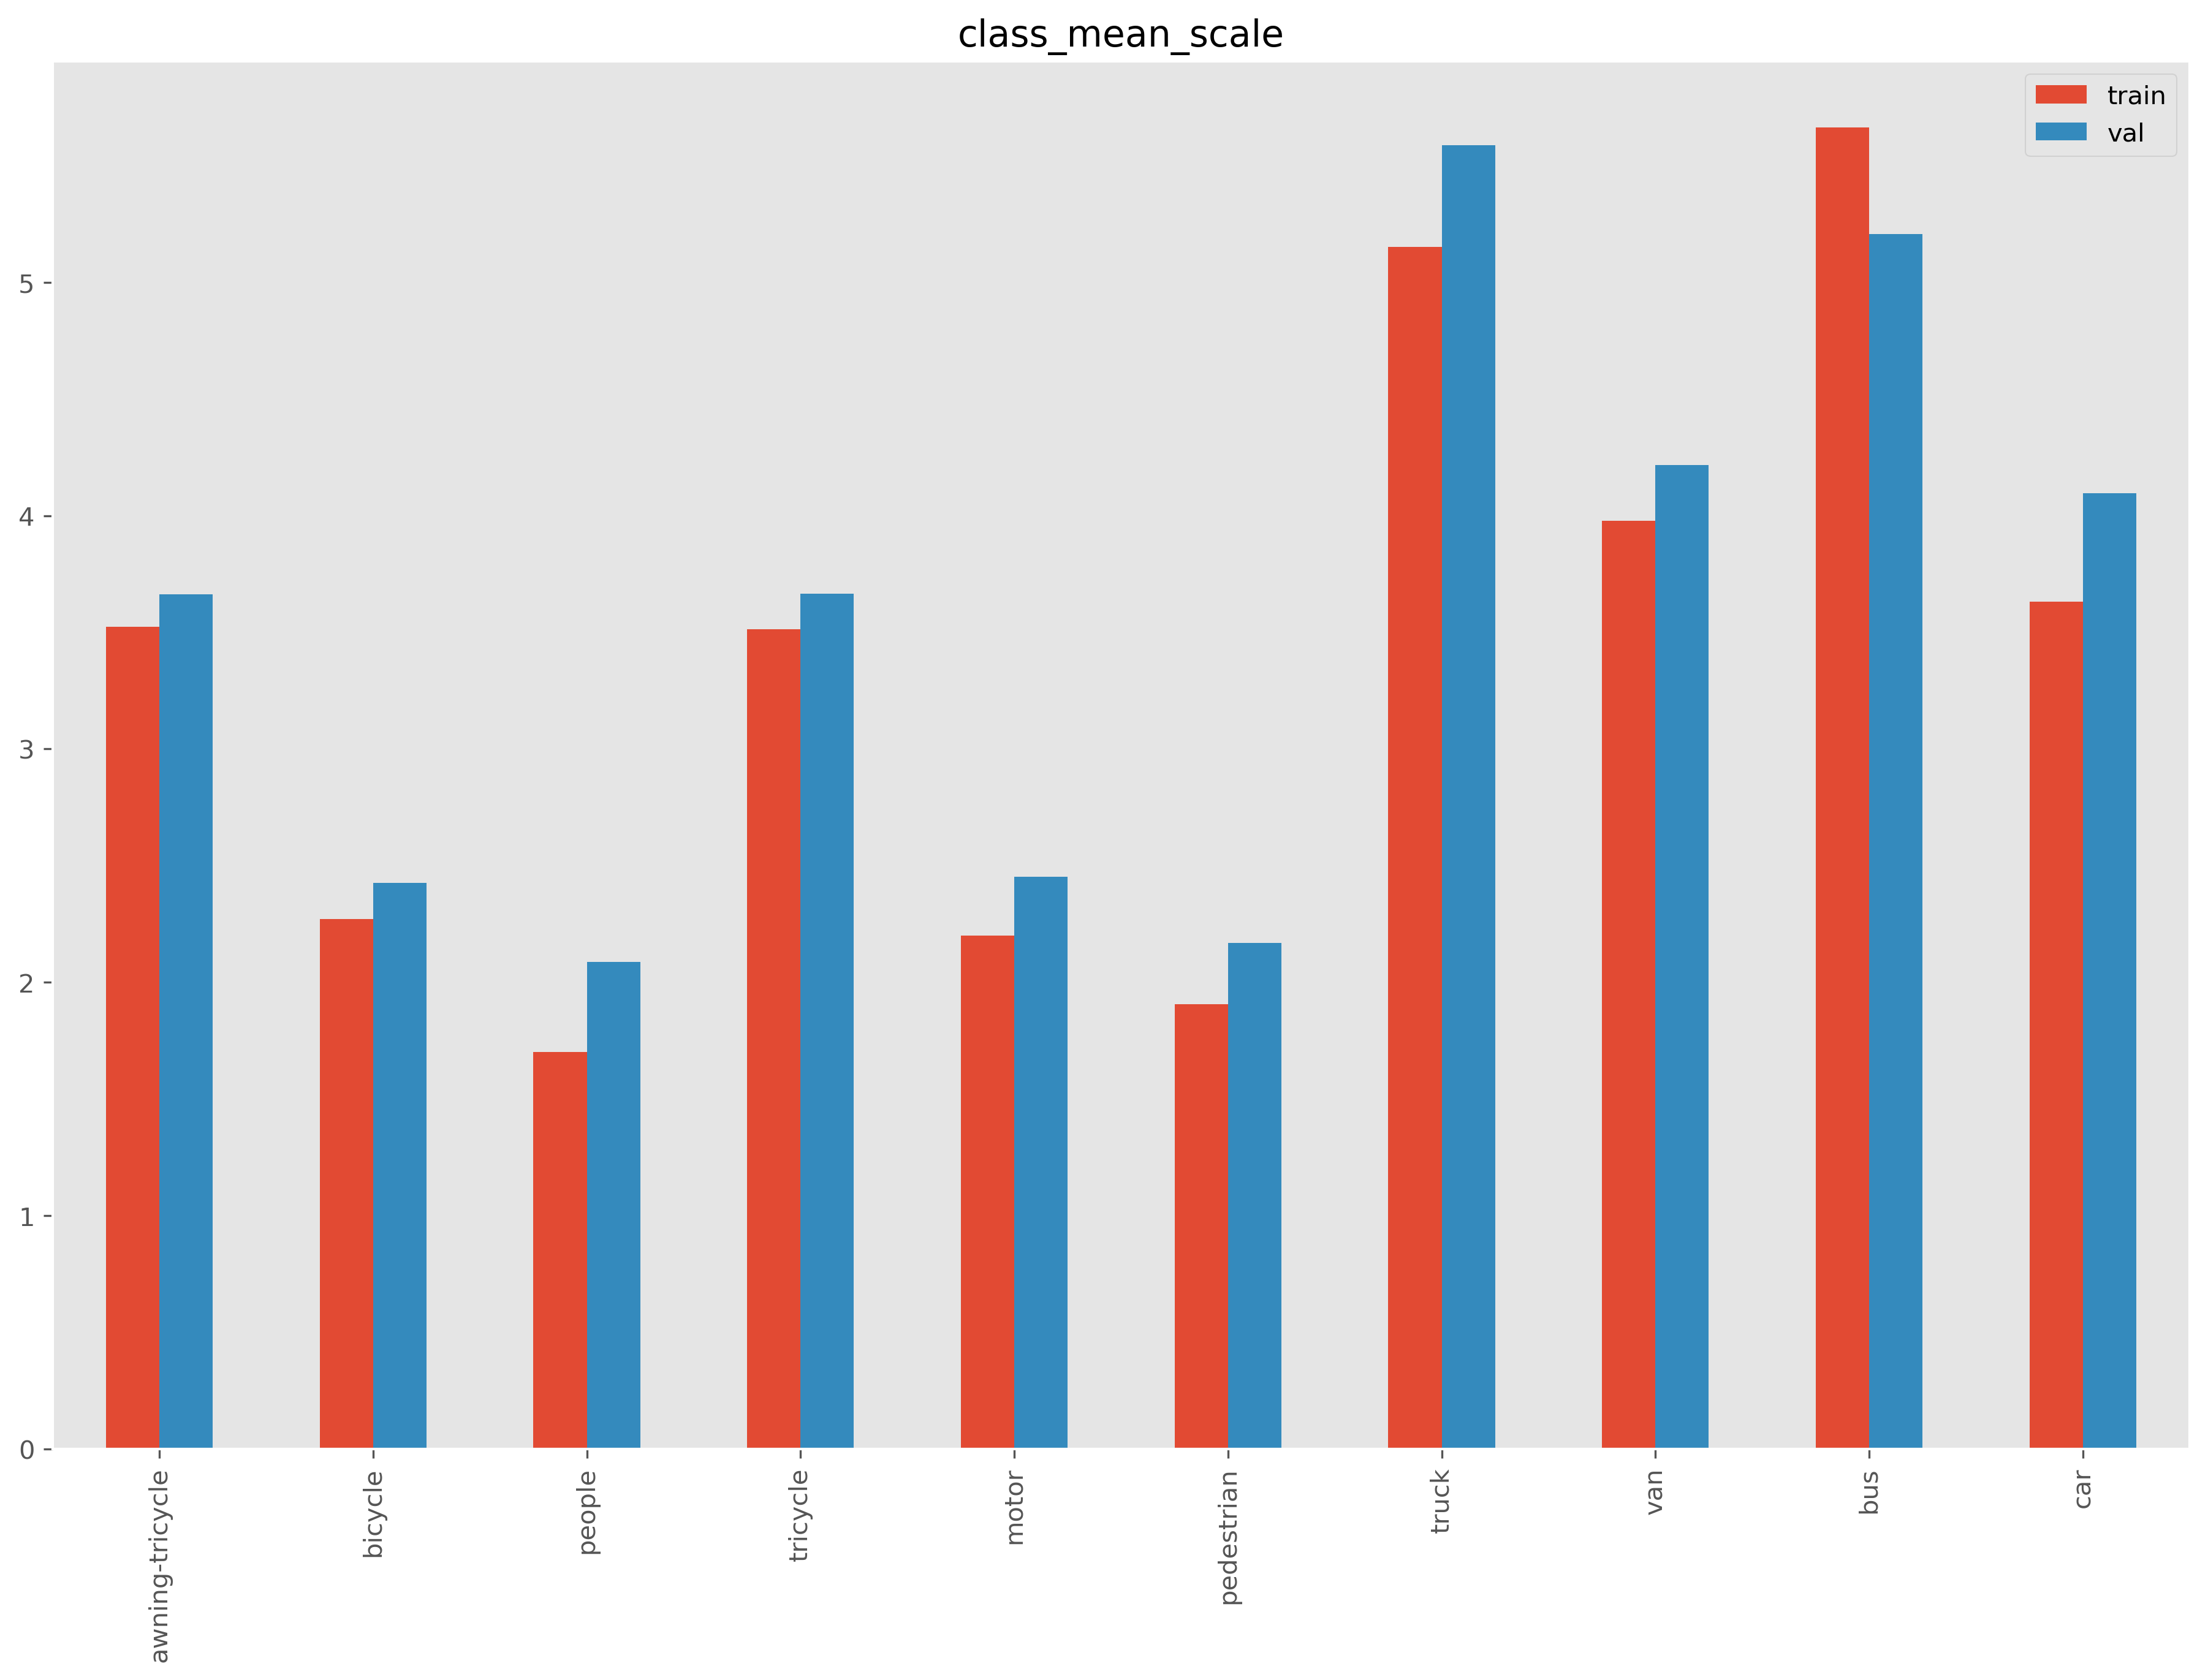

In [65]:
fig = plt.figure(dpi=300,figsize=(15,10))
plt.style.use('ggplot')
# plt.title('cls_scale_mean')
df_scale_mean = pd.DataFrame([],columns=["train","val","ap"])
for i,key in enumerate(val_scale_count.keys()):
    df_scale_mean.loc[i] = [np.mean(train_scale_count[key]),np.mean(val_scale_count[key]),ap_dt[key]]
df_scale_mean.index = val_scale_count.keys()
df_scale_mean.sort_values("ap",inplace=True)
ax = plt.subplot(1, 1, 1)   #添加子图
df_scale_mean[["train","val"]].plot(kind="bar",title="class_mean__scale",grid=False,ax=ax)
# sns.barplot(x="dataset", y="scale", hue="class", data=df_scale_mean,capsize=.05)
plt.show()

In [70]:
# 使用相较于尺度小小people，计算相对尺度。
df_relative_scale_mean = df_scale_mean.copy(deep=True)
base_scale = df_scale_mean[["train","val"]].loc["people"]
df_relative_scale_mean["train"] = df_relative_scale_mean["train"].map(lambda x:x/base_scale["train"])
df_relative_scale_mean["val"] = df_relative_scale_mean["val"].map(lambda x:x/base_scale["val"])

<AxesSubplot:title={'center':'class_mean_relative_scale'}>

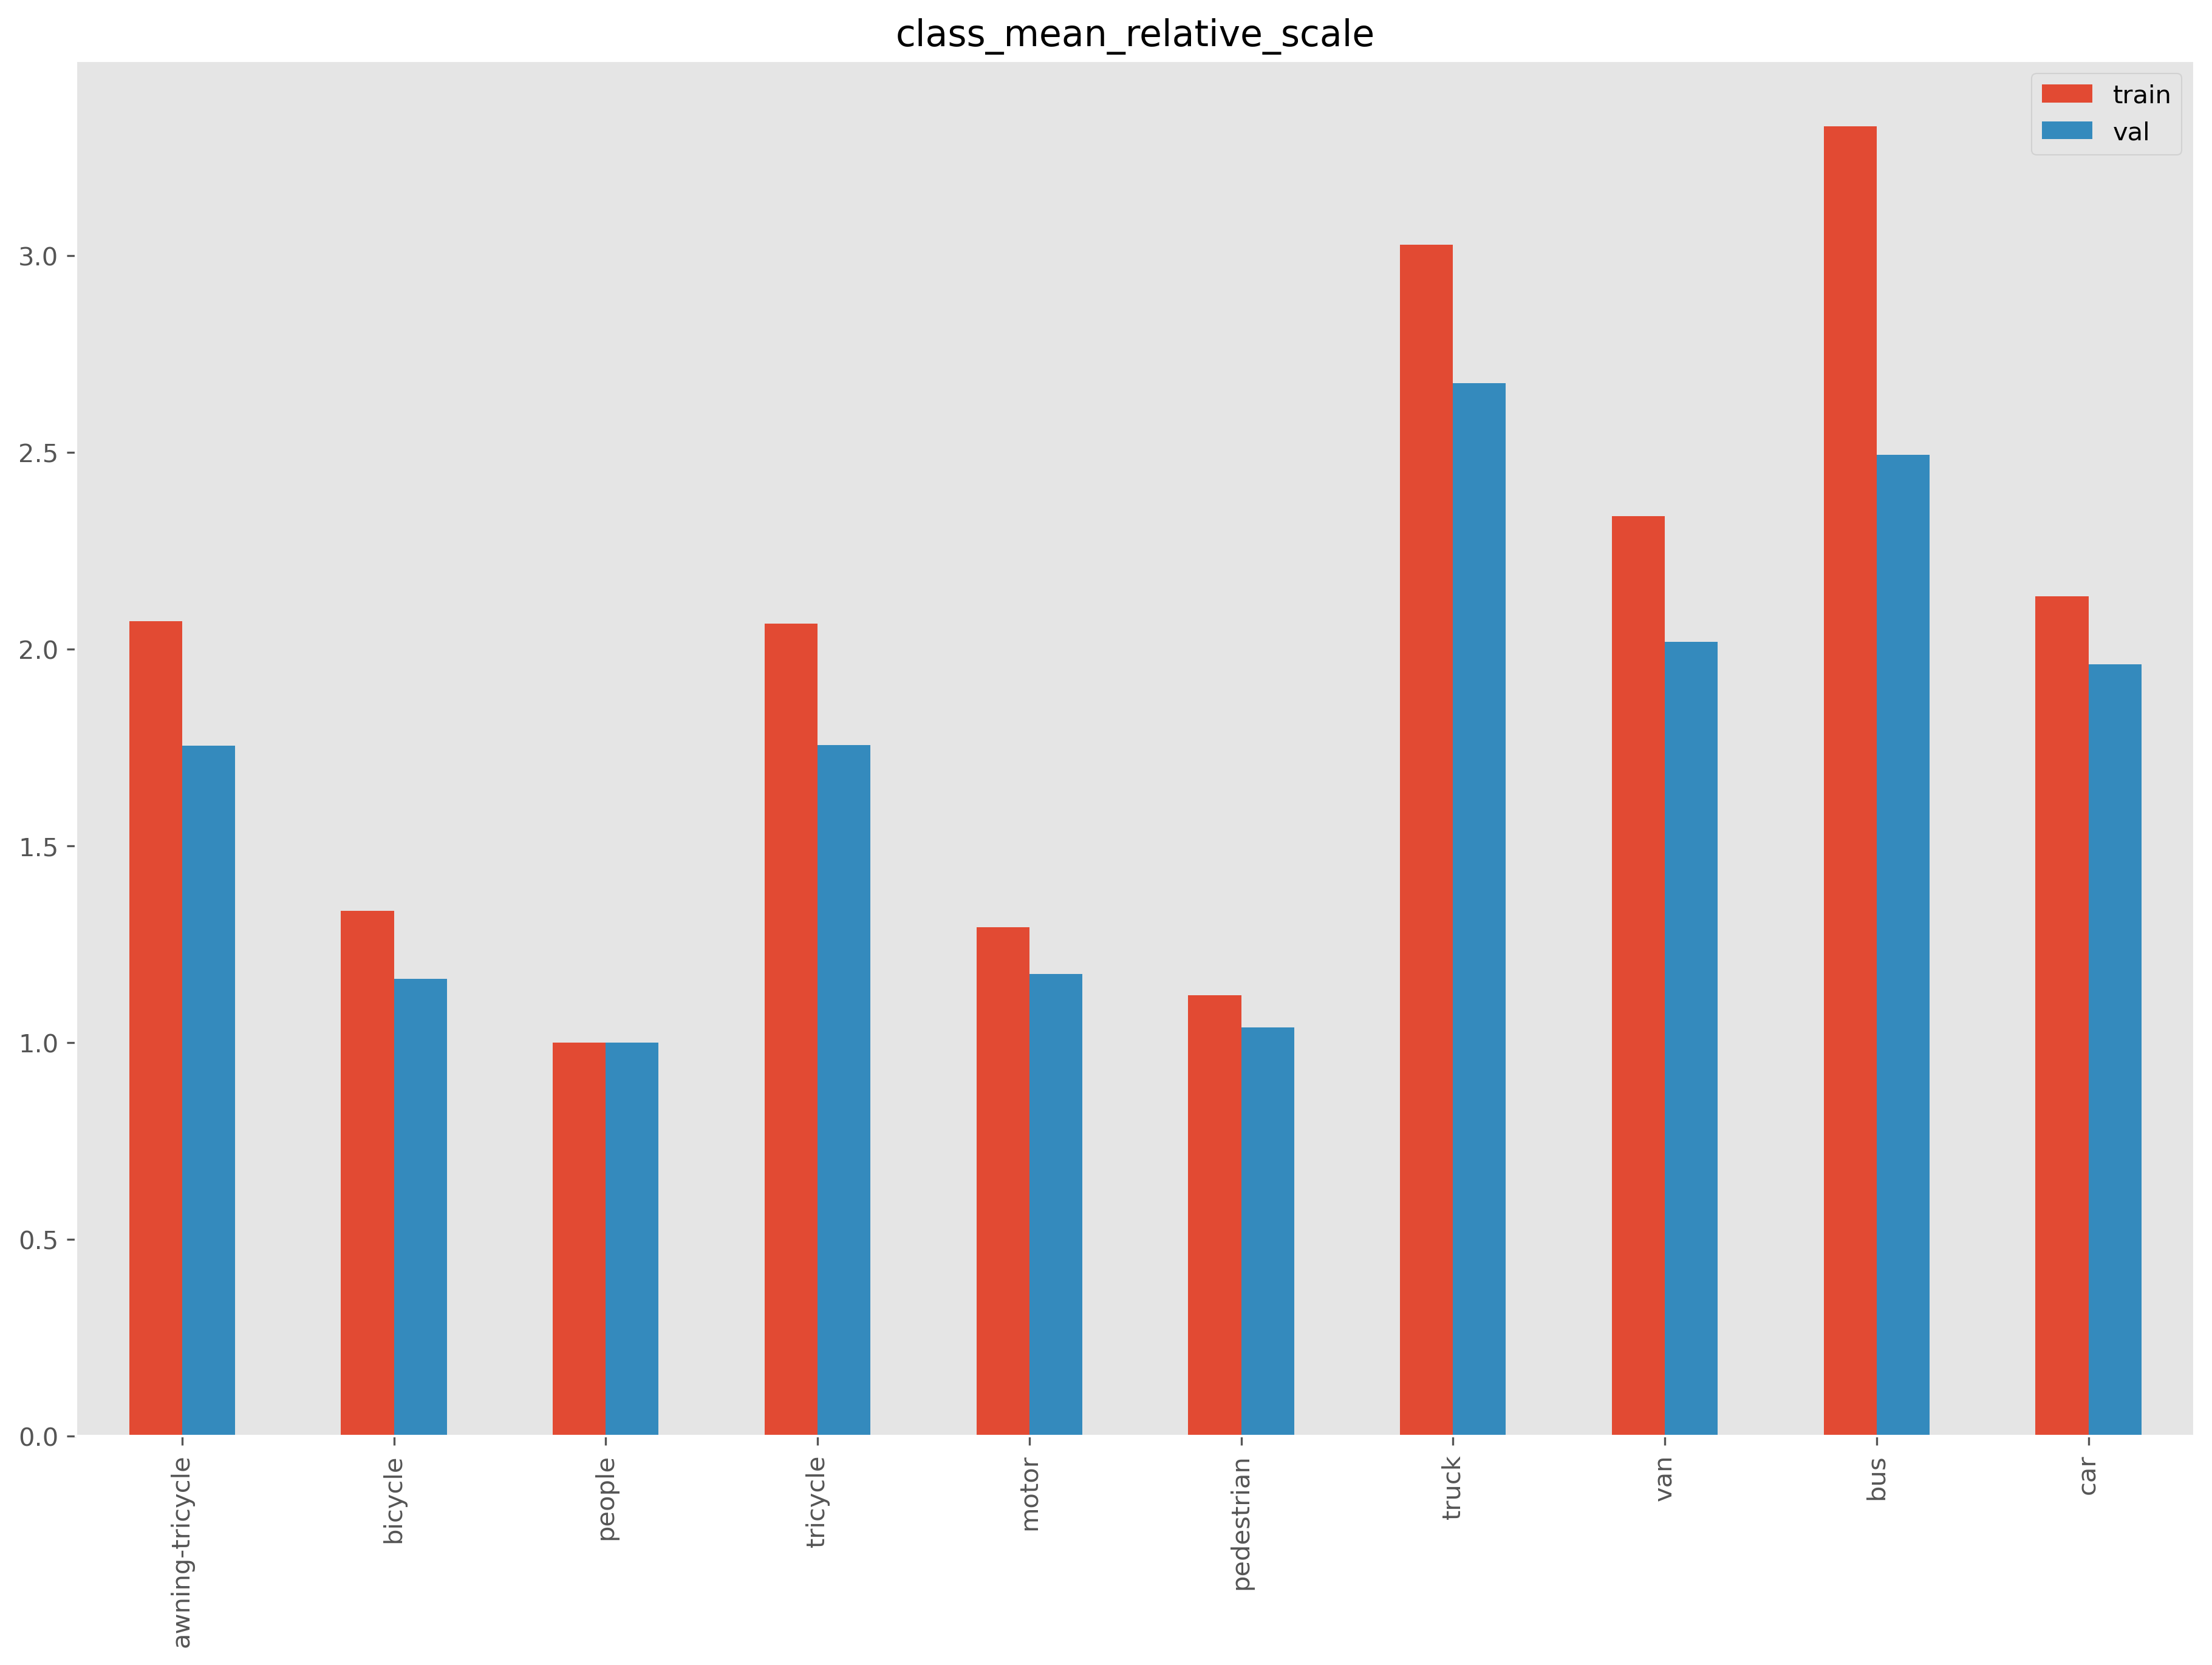

In [73]:
fig = plt.figure(dpi=300,figsize=(15,10))
plt.style.use('ggplot')
# plt.title('cls_scale_mean')
df_relative_scale_mean.sort_values("ap",inplace=True)
ax = plt.subplot(1, 1, 1)   #添加子图
df_relative_scale_mean[["train","val"]].plot(kind="bar",title="class_mean_relative_scale",grid=False,ax=ax)
# sns.barplot(x="dataset", y="scale", hue="class", data=df_scale_mean,capsize=.05)

## 统计各个每个图像中的box数量

In [47]:
# 统计每张图片中box的数量，给nms作参考
import pandas as pd
val_box_num_count = [len(sample["detections"]["detections"]) for sample in visdrone_dataset]   
train_box_num_count = [len(sample["detections"]["detections"]) for sample in visdrone_dataset_train]   

val_b_num_count = pd.Series(val_box_num_count)
train_b_num_count = pd.Series(train_box_num_count)

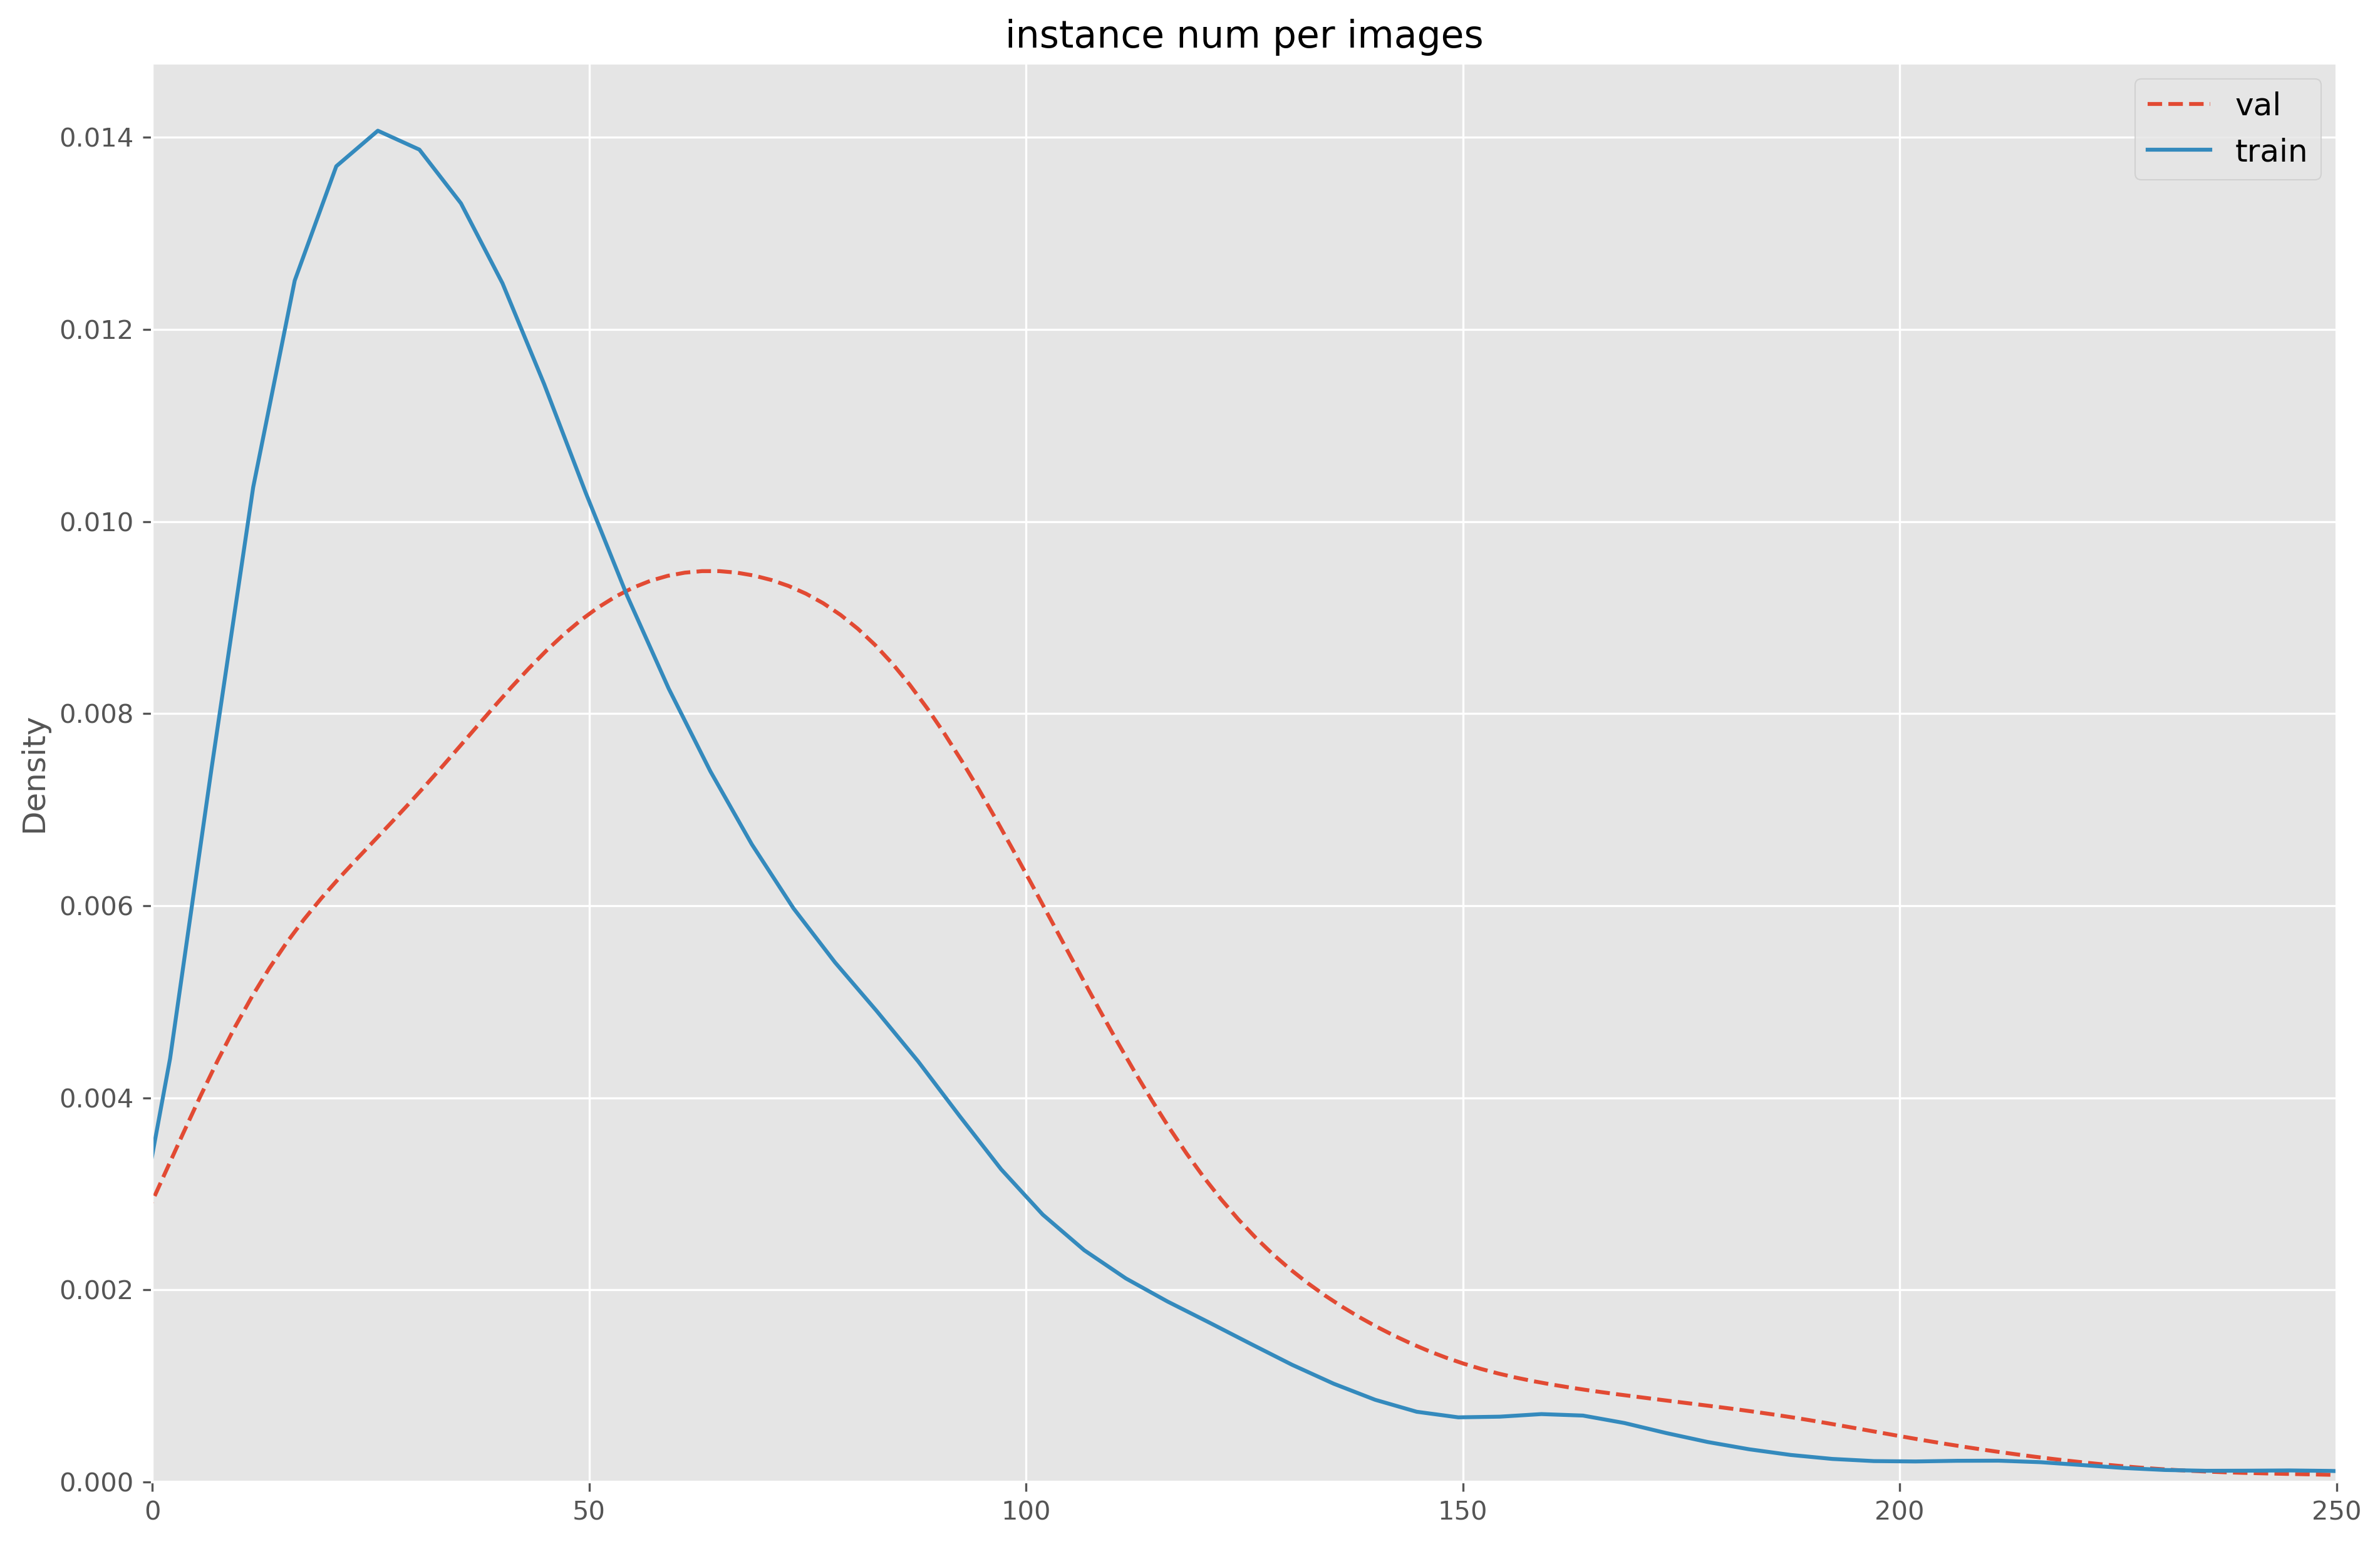

In [49]:
import seaborn as sns
# b_num_count.plot.hist(bins=80) #直方图
# b_num_count.plot.density()  #概率密度图
plt.figure(dpi=300,figsize=(15,10))
plt.title('instance num per images')
plt.style.use('ggplot')
# plt.style.use('seaborn')
plt.rcParams['axes.unicode_minus']=False
plt.xlim((0,250))

sns.kdeplot(val_b_num_count, label = "val",linestyle='--')
sns.kdeplot(train_b_num_count, label = "train",linestyle='-')
plt.legend(prop={'size': 12})
plt.show()

### 2. 添加模型预测结果

In [3]:
import mmcv

# 加载模型输出
reppoint_result =  mmcv.load("/home/wsg/sod/coco_tools/results/reppoints_v2_visdrone_val_results-nms320.bbox.json")
ufpmp_result = mmcv.load("/home/wsg/sod/coco_tools/results/ufpmp_visdrone_val_results.bbox.json")
"""
我的gt和result的image_id都是从0开始编码的，548张图片的id为0-547
但是coco数据集是从1开始编码的,fiftyone会将0号图片与1号result做匹配。#这里的索引为0-547
因此我需要将result中所有image_id+1
"""
for i in range(len(reppoint_result)):
    reppoint_result[i]["image_id"] += 1
for i in range(len(ufpmp_result)):
    ufpmp_result[i]["image_id"] += 1

/home/wsg/anaconda3/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [4]:
import fiftyone.utils.coco as fouc
# 添加输出到dataset
classes = visdrone_dataset.default_classes
fouc.add_coco_labels(visdrone_dataset, "reppoint_pred", reppoint_result, classes)
fouc.add_coco_labels(visdrone_dataset, "ufpmp_pred", ufpmp_result, classes)

### 3. 计算Map

In [7]:
reppoint_results = visdrone_dataset.evaluate_detections(
    "reppoint_pred",
    gt_field="detections",
    method="coco",
    compute_mAP=True,
    eval_key="reppoint_eval"    #指定这个计算结果的id
)
print(reppoint_results.mAP())  
reppoint_results.print_report(classes=visdrone_dataset.default_classes)

Evaluating detections...
 100% |█████████████████| 548/548 [2.0m elapsed, 0s remaining, 4.7 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 548/548 [3.5m elapsed, 0s remaining, 2.7 samples/s]      
0.23853579941417116
                 precision    recall  f1-score   support

     pedestrian       0.17      0.74      0.28      8844
         people       0.15      0.67      0.24      5125
        bicycle       0.06      0.56      0.10      1287
            car       0.34      0.91      0.49     14064
            van       0.12      0.74      0.21      1975
          truck       0.08      0.67      0.15       750
       tricycle       0.09      0.62      0.16      1045
awning-tricycle       0.07      0.55      0.13       532
            bus       0.09      0.69      0.16       251
          motor       0.16      0.79      0.27      4886

      micro avg       0.18      0.79      0.30     38759
      macro avg       0.13      0.69      0.22     38759
   weighted avg     

In [8]:
# 绘制PR曲线
reppoint_plot = reppoint_results.plot_pr_curves(classes=visdrone_dataset.default_classes)
reppoint_plot.show()

FigureWidget({
    'data': [{'customdata': array([0.95540088, 0.90589638, 0.89468558, 0.8855849 , 0.87651124, …

In [12]:
visdrone_dataset.get_evaluation_info("reppoint_eval")  #查看评估的参数

{
    "key": "reppoint_eval",
    "version": "0.17.2",
    "timestamp": "2022-11-15T13:33:24.105000",
    "config": {
        "method": "coco",
        "cls": "fiftyone.utils.eval.coco.COCOEvaluationConfig",
        "pred_field": "reppoint_pred",
        "gt_field": "detections",
        "iou": 0.5,
        "classwise": true,
        "iscrowd": "iscrowd",
        "use_masks": false,
        "use_boxes": false,
        "tolerance": null,
        "compute_mAP": true,
        "iou_threshs": [
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            0.9,
            0.95
        ],
        "max_preds": 100,
        "error_level": 1
    }
}

In [5]:
ufpmp_results = visdrone_dataset.evaluate_detections(
    "ufpmp_pred",
    gt_field="detections",
    method="coco",
    compute_mAP=True,
    eval_key="ufpmp_eval"
)
print(ufpmp_results.mAP())
ufpmp_results.print_report(classes=visdrone_dataset.default_classes)

Evaluating detections...
 100% |█████████████████| 548/548 [1.3m elapsed, 0s remaining, 6.6 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 548/548 [2.3m elapsed, 0s remaining, 3.9 samples/s]      
0.3597297619506751
                 precision    recall  f1-score   support

     pedestrian       0.27      0.75      0.39      8844
         people       0.23      0.70      0.35      5125
        bicycle       0.10      0.62      0.17      1287
            car       0.40      0.93      0.56     14064
            van       0.12      0.83      0.21      1975
          truck       0.06      0.79      0.11       750
       tricycle       0.11      0.73      0.19      1045
awning-tricycle       0.07      0.68      0.12       532
            bus       0.04      0.84      0.07       251
          motor       0.24      0.81      0.38      4886

      micro avg       0.23      0.82      0.36     38759
      macro avg       0.16      0.77      0.25     38759
   weighted avg      

In [7]:
ufpmp_plot = ufpmp_results.plot_pr_curves(classes=visdrone_dataset.default_classes)
ufpmp_plot.show()

FigureWidget({
    'data': [{'customdata': array([0.96449852, 0.94744127, 0.94259877, 0.93863249, 0.93447978, …

## 查看TP FP FN的patch

In [8]:
eval_patches = visdrone_dataset.to_evaluation_patches("ufpmp_eval")
print(eval_patches)
print(eval_patches.count_values("type"))


session = fo.launch_app(visdrone_dataset, view=eval_patches, auto=False)
# session.view = eval_patches
session.open_tab()
session.show()

Dataset:     2022.11.22.22.36.32
Media type:  image
Num patches: 146186
Patch fields:
    id:         fiftyone.core.fields.ObjectIdField
    sample_id:  fiftyone.core.fields.ObjectIdField
    filepath:   fiftyone.core.fields.StringField
    tags:       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    ufpmp_pred: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    crowd:      fiftyone.core.fields.BooleanField
    type:       fiftyone.core.fields.StringField
    iou:        fiftyone.core.fields.FloatField
View stages:
    1. ToEvaluationPatches(eval_key='ufpmp_eval', config=None)
{'fp': 107427, 'fn': 7152, 'tp': 31607}
Session launched. Run `session.show()` to open the App in a cell output.


<IPython.core.display.Javascript object>

## 查看最佳和最差的样本

In [14]:
# 查看的样本
from fiftyone import ViewField as F
high_conf_view =  visdrone_dataset.filter_labels("ufpmp_pred", F("confidence") > 0.4, only_matches=False)
eval_fp = high_conf_view.sort_by("ufpmp_eval_fp", reverse=True)  #找到ufp假阳做多的图片
session = fo.launch_app(visdrone_dataset, view=eval_fp, auto=False)
# session.view = eval_patches
session.open_tab()
session.show()

Session launched. Run `session.show()` to open the App in a cell output.


<IPython.core.display.Javascript object>

## 只计算高置信度的box

In [12]:
from fiftyone import ViewField as F
high_conf =  visdrone_dataset.filter_labels("reppoint_pred", F("confidence") > 0.4, only_matches=False)
reppoint_high_conf = high_conf.evaluate_detections(
    "reppoint_pred",
    gt_field="detections",
    method="coco",
    compute_mAP=True,
)
print(reppoint_high_conf.mAP())
reppoint_high_conf.print_report(classes=visdrone_dataset.default_classes)

Evaluating detections...
 100% |█████████████████| 548/548 [40.1s elapsed, 0s remaining, 14.0 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 548/548 [58.6s elapsed, 0s remaining, 10.2 samples/s]     
0.20062820790588018
                 precision    recall  f1-score   support

     pedestrian       0.57      0.55      0.56      8844
         people       0.60      0.39      0.47      5125
        bicycle       0.42      0.22      0.29      1287
            car       0.74      0.81      0.77     14064
            van       0.60      0.43      0.50      1975
          truck       0.56      0.38      0.45       750
       tricycle       0.58      0.23      0.33      1045
awning-tricycle       0.36      0.15      0.21       532
            bus       0.72      0.50      0.59       251
          motor       0.58      0.51      0.54      4886

      micro avg       0.64      0.58      0.61     38759
      macro avg       0.57      0.42      0.47     38759
   weighted avg  

In [11]:
from fiftyone import ViewField as F
high_conf =  visdrone_dataset.filter_labels("ufpmp_pred", F("confidence") > 0.4, only_matches=False)
ufpmp_high_conf = high_conf.evaluate_detections(
    "ufpmp_pred",
    gt_field="detections",
    method="coco",
    compute_mAP=True,
)
print(ufpmp_high_conf.mAP())
ufpmp_high_conf.print_report(classes=visdrone_dataset.default_classes)


Evaluating detections...
 100% |█████████████████| 548/548 [41.5s elapsed, 0s remaining, 13.3 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 548/548 [1.1m elapsed, 0s remaining, 9.1 samples/s]      
0.3361735840049871
                 precision    recall  f1-score   support

     pedestrian       0.69      0.67      0.68      8844
         people       0.64      0.59      0.61      5125
        bicycle       0.40      0.50      0.45      1287
            car       0.80      0.88      0.84     14064
            van       0.56      0.65      0.61      1975
          truck       0.51      0.59      0.55       750
       tricycle       0.45      0.55      0.49      1045
awning-tricycle       0.26      0.41      0.31       532
            bus       0.63      0.76      0.69       251
          motor       0.63      0.69      0.66      4886

      micro avg       0.68      0.72      0.70     38759
      macro avg       0.56      0.63      0.59     38759
   weighted avg    

### 备用代码

In [ ]:
# 发现
# 删除0号图片的部分box
num = [10,9,8,7,6]  #前5张图片[0,1,2,3,4]减少后应该为90,91,92,93,94个box
for i in range(len(reppoint_result)):
    ann = reppoint_result[i]
    j = ann["image_id"]
    if 0<=j<=4 and num[j]>0:
        reppoint_result[i]["image_id"] = 30
        num[j] -= 1
    if sum(num)<=0:
        break

box_num = []
for i in range(5):
    count = 0
    for ann in reppoint_result:
        if ann["image_id"] == i:
            count += 1
    box_num.append(count)
box_num

"""
知道错配的原因了,0号图片匹配的是1号图片的result box
"""